## Imports

In [156]:
import requests
import os
import pathlib
import sys
import torch
import torch_geometric
import matplotlib.pyplot as plt
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))
from helpers.Neo4jMovieLensMetadata import Neo4jMovieLensMetaData
from helpers.dataset import load_data_dataset
from helpers.get_model import get_model, get_model_name
from helpers.recommendations import make_predictions, recommend

## Action

we have just added a new user with user_id 673

### Fetch the dataset and the model

In [165]:
dataset, data = load_data_dataset("bolt://localhost:7687", "neo4j", "admin")

Processing...


Encoding title...
Encoding original_title...
Encoding fastRP_genres...
Encoding fastRP_keywords...
Encoding fastRP_cast...
Encoding fastRP_crew...
Encoding fastRP_production_companies...
Encoding fastRP_production_countries...
Encoding fastRP_spoken_languages...
[torch.Size([9067, 384]), torch.Size([9067, 384]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256]), torch.Size([9067, 256])]


Done!


In [166]:
model = get_model(data)

In [167]:
model

Model(
  (encoder): GraphModule(
    (convs): Module(
      (0): Module(
        (user__rates__movie): SAGEConv(-1, 16, aggr=mean)
        (movie__rev_rates__user): SAGEConv(-1, 16, aggr=mean)
      )
      (1): Module(
        (user__rates__movie): SAGEConv(16, 16, aggr=mean)
        (movie__rev_rates__user): SAGEConv(16, 16, aggr=mean)
      )
    )
  )
  (decoder): EdgeDecoder(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=16, bias=True)
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=16, bias=True)
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): Linear(in_features=16, out_features=16, bias=True)
      (6): Linear(in_features=16, out_features=16, bias=True)
      (7): Linear(in_features=16, out_features=16, bias=True)
      (8): Linear(in_features=16, out_features=16, bias=True)
      (9): Linear(in_features=16

In [168]:
def nested_children(m: torch.nn.Module):
    children = dict(m.named_children())
    output = {}
    if children == {}:
        # if module has no children; m is last child! :O
        return m
    else:
        # look for children from children... to the last child!
        for name, child in children.items():
            try:
                output[name] = nested_children(child)
            except TypeError:
                output[name] = nested_children(child)
    return output

In [169]:
nested_children(model.encoder)

{'convs': {'0': {'user__rates__movie': {'aggr_module': MeanAggregation(),
    'lin_l': Linear(671, 16, bias=True),
    'lin_r': Linear(2560, 16, bias=False)},
   'movie__rev_rates__user': {'aggr_module': MeanAggregation(),
    'lin_l': Linear(2560, 16, bias=True),
    'lin_r': Linear(671, 16, bias=False)}},
  '1': {'user__rates__movie': {'aggr_module': MeanAggregation(),
    'lin_l': Linear(16, 16, bias=True),
    'lin_r': Linear(16, 16, bias=False)},
   'movie__rev_rates__user': {'aggr_module': MeanAggregation(),
    'lin_l': Linear(16, 16, bias=True),
    'lin_r': Linear(16, 16, bias=False)}}}}

### Predict for the new user

In [170]:
data.x_dict["user"].shape

torch.Size([675, 675])

In [171]:
data.edge_index_dict[("user", "rates", "movie")].shape

torch.Size([2, 100717])

#### test for the current user

In [172]:
predictions = make_predictions(dataset, data, model, 673)

IN GNN ENCODER


RuntimeError: mat1 and mat2 shapes cannot be multiplied (9067x675 and 674x16)

### Let's dive...

#### Problem

* new adjacency matrix is of shape [num_movies, num_users]
* old weight matrix of the model is of shape [old_num_users, hidden_channels]
* num_users != old_num_users

so we will modify by hand the weight matrix of the model and add one new random row for the new user

In [173]:
def nested_children(m: torch.nn.Module):
    children = dict(m.named_children())
    output = {}
    if children == {}:
        # if module has no children; m is last child! :O
        return m
    else:
        # look for children from children... to the last child!
        for name, child in children.items():
            try:
                output[name] = nested_children(child)
            except TypeError:
                output[name] = nested_children(child)
    return output

In [174]:
nested_children(model.encoder)

{'convs': {'0': {'user__rates__movie': {'aggr_module': MeanAggregation(),
    'lin_l': Linear(671, 16, bias=True),
    'lin_r': Linear(2560, 16, bias=False)},
   'movie__rev_rates__user': {'aggr_module': MeanAggregation(),
    'lin_l': Linear(2560, 16, bias=True),
    'lin_r': Linear(671, 16, bias=False)}},
  '1': {'user__rates__movie': {'aggr_module': MeanAggregation(),
    'lin_l': Linear(16, 16, bias=True),
    'lin_r': Linear(16, 16, bias=False)},
   'movie__rev_rates__user': {'aggr_module': MeanAggregation(),
    'lin_l': Linear(16, 16, bias=True),
    'lin_r': Linear(16, 16, bias=False)}}}}

2560

In [190]:
num_users = dataset.my_mappings["users_mapping"].__len__()
convs = [conv for conv in model.encoder.convs.children()]
conv = convs[0]
dimension_to_ignore = nested_children(model.encoder)["convs"]["0"]["user__rates__movie"]["lin_r"].weight.shape[1]
for gnn_layer in conv.children():
    for layer in gnn_layer.children():
        if isinstance(layer, torch_geometric.nn.dense.Linear):
            print(layer, end=": ")
            weight_matrix_users = layer.weight.shape[1]
            if (weight_matrix_users == dimension_to_ignore):
                    print("not a layer that throws the errors")
                    continue
            if (weight_matrix_users == num_users):
                print(f"{num_users} users up to date")
            else:
                print(f"should add {num_users - weight_matrix_users} users")

Linear(671, 16, bias=True): 675 users up to date
Linear(2560, 16, bias=False): not a layer that throws the errors
Linear(2560, 16, bias=True): not a layer that throws the errors
Linear(671, 16, bias=False): 675 users up to date


In [177]:
# updates the weight matrix of the linear layers of the model
# to have a dimension of 674 instead of 671
# this is because the model was trained on a dataset with 671 users
# and the new dataset has 674 users

def update_model(model):
    num_users = dataset.my_mappings["users_mapping"].__len__()
    convs = [conv for conv in model.encoder.convs.children()]
    conv = convs[0]

    for gnn_layer in conv.children():
        for layer in gnn_layer.children():
            if isinstance(layer, torch_geometric.nn.dense.Linear):
                print(layer, end=": ")
                
                weight_matrix_users = layer.weight.shape[1]
                if (weight_matrix_users == 2560):
                    print("not a layer that throws the errors")
                    continue

                if (weight_matrix_users == num_users):
                    print(f"{num_users} users up to date")
                else:
                    new_cols_num = num_users - weight_matrix_users
                    if new_cols_num > 0:
                        # add new columns with zeros to the weight matrix
                        new_cols = torch.zeros(
                            layer.weight.shape[0], new_cols_num)
                        layer.weight = torch.nn.Parameter(
                            torch.cat((layer.weight, new_cols), dim=1))
                        print(f"should add {new_cols_num} users")
                    else:
                        print(f"should remove {-new_cols_num} users")

In [178]:
update_model(model, data)

Linear(671, 16, bias=True): should add 1 users
Linear(2560, 16, bias=False): not a layer that throws the errors
Linear(2560, 16, bias=True): not a layer that throws the errors
Linear(671, 16, bias=False): should add 1 users


IN GNN ENCODER
OUT OF GNN ENCODER


(0.0, 5.0)

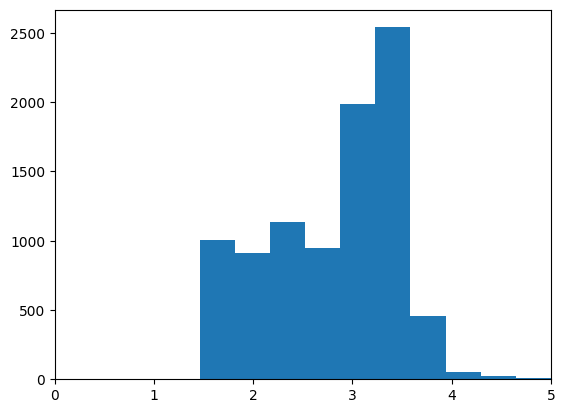

In [185]:
predictions = make_predictions(dataset, data, model, 674)
vals = [pred["rating"] for pred in predictions["predictedRatings"]]
plt.hist(vals)
# set the range of the x-axis
plt.xlim(0, 5)

In [186]:
model_name = get_model_name()
model_name

'pickled_model_small'

In [187]:
torch.save(model, model_name)